<a href="https://colab.research.google.com/github/gemammercado/IsraelPalestineResearch/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import re
import zipfile
import nltk
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

os.environ["WANDB_DISABLED"] = "true"

os.environ['SHELL'] = '/opt/homebrew/bin/bash'
nltk.download('vader_lexicon')


drive.mount('/content/drive')


csv_path = '/content/drive/MyDrive/bert_predictions.csv'
df = pd.read_csv(csv_path)

"""!pip uninstall nltk -y # Uninstall NLTK
!pip install --upgrade --force-reinstall nltk # Reinstall NLTK

import nltk
nltk.download('vader_lexicon') # Download vader_lexicon"""

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


"!pip uninstall nltk -y # Uninstall NLTK\n!pip install --upgrade --force-reinstall nltk # Reinstall NLTK\n\nimport nltk\nnltk.download('vader_lexicon') # Download vader_lexicon"


Now we have a filtered_df and csv of the final data we are going to use.

In [ ]:
sia = SentimentIntensityAnalyzer()

vader_sample_size = 10000
bert_sample_size = 250000

vader_df = df.sample(n=vader_sample_size, random_state=42)

remaining_df = df.drop(vader_df.index)

bert_df = remaining_df.sample(n=bert_sample_size, random_state=42)

print(f"VADER subset size: {len(vader_df)}")
print(f"BERT subset size: {len(bert_df)}")

VADER subset size: 10000
BERT subset size: 250000


In [ ]:
def clean_text(self_text):
    text = re.sub(r"http\S+", "", self_text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    text = self_text.lower().strip()
    return text

vader_df['clean_text'] = vader_df['self_text'].apply(lambda x: clean_text(str(x)))

print(vader_df.head())

        comment_id  score                                          self_text  \
1418796    ka8602d      1                           More tunnels and rockets   
1141828    kf26cmy      4  Link to the actual article.\n\n**Unless you en...   
843056     ksi5j8a      1  Thanks for an insight into this and for being ...   
155018     ljda27r      2  You’re angry because you can’t figure out what...   
629993     kzqu9cr      5                            So less than 20 left...   

               subreddit         created_time  post_id           author_name  \
1418796        worldnews  2023-11-21 23:07:53  180pznz    Pyjama_Llama_Karma   
1141828    AskMiddleEast  2023-12-27 00:51:55  18r9g5u   itsasnowconemachine   
843056   IsraelPalestine  2024-02-28 07:14:51  1b1xmh8      FractalMetaphors   
155018   IsraelPalestine  2024-08-22 12:34:15  1ey57vs        MissingNo_000_   
629993         worldnews  2024-04-15 22:03:50  1c4tcel  No-Introduction-6368   

         controversiality  ups  downs 

In [ ]:
bert_df['clean_text'] = bert_df['self_text'].apply(lambda x: clean_text(str(x)))

print(bert_df.head())

        comment_id  score                                          self_text  \
736101     kwcam5d     15  Pakistanis are dumb sometimes I swear, this is...   
926993     kppuklp      1  Well, sounds like you made up your mind regard...   
287717     lc3rfkg      1  Things that might be controversial one day are...   
1221879    kdbvkf5      2                                        🪂🪂🪂     🔻🔻🔻   
22376      lpxymc7     13  Just to add to this. They don't know if those ...   

               subreddit         created_time  post_id        author_name  \
736101     AskMiddleEast  2024-03-24 14:16:00  1bmjuzh     Wanttodate1995   
926993   IsraelPalestine  2024-02-10 00:45:30  1amyajr  pinkytoesupremacy   
287717   IsraelPalestine  2024-07-07 22:10:06  1dxegor   CreativeRealmsMC   
1221879    AskMiddleEast  2023-12-14 15:20:22  18hrqyb   Its_my_ghenetiks   
22376          worldnews  2024-10-02 07:29:47  1fua33m              Brewe   

         controversiality  ups  downs  ...  user_comment

In [ ]:
vader_df['vader_sentiment'] = vader_df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

vader_df['sentiment_label'] = vader_df['vader_sentiment'].apply(lambda score: 'extreme negative' if score <-0.5 else
                                                                  'negative' if -0.5<= score < -.05 else
                                                                  'positive' if score >=0.05 else
                                                                  'neutral')

In [ ]:
print(vader_df[['clean_text', 'vader_sentiment', 'sentiment_label']].head())

                                                clean_text  vader_sentiment  \
1418796                           more tunnels and rockets           0.0000   
1141828  link to the actual article.\n\n**unless you en...           0.4710   
843056   thanks for an insight into this and for being ...          -0.8359   
155018   you’re angry because you can’t figure out what...           0.3400   
629993                             so less than 20 left...           0.0000   

          sentiment_label  
1418796           neutral  
1141828          positive  
843056   extreme negative  
155018           positive  
629993            neutral  


In [ ]:
train_df, test_df = train_test_split(vader_df, test_size=0.2, random_state=42)

label_map = {'extreme negative': 0, 'negative':1, 'neutral': 2, 'positive':3}
train_labels = train_df['sentiment_label'].map(label_map).tolist()
test_labels = test_df['sentiment_label'].map(label_map).tolist()

In [ ]:
print(train_df.columns)

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time', 'clean_text', 'vader_sentiment',
       'sentiment_label'],
      dtype='object')


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

train_encodings = tokenize_data(train_df['clean_text'].tolist())
test_encodings = tokenize_data(test_df['clean_text'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item


In [ ]:
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

Define and train BERT

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = len(label_map))

training_args = TrainingArguments(
    output_dir = './results',
    save_steps = 500,
    save_total_limit = 2,
    evaluation_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs=3,
    weight_decay = 0.01
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Save model and training state after each epoch
trainer.save_model('/content/drive/MyDrive/bert_training/bert_classifier')
trainer.save_state()

In [ ]:
import torch
torch.save(train_encodings, '/content/drive/MyDrive/train_encodings.pt')
torch.save(test_encodings, '/content/drive/MyDrive/test_encodings.pt')
torch.save(train_labels, '/content/drive/MyDrive/train_labels.pt')
torch.save(test_labels, '/content/drive/MyDrive/test_labels.pt')


In [ ]:
trainer.train()

<ipython-input-26-89b9e70d32b8>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.744300,0.685571
2,0.493500,0.669349


In [ ]:
trainer.train(resume_from_checkpoint='/content/drive/MyDrive/bert_training/bert_classifier/checkpoint-2000')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
3,0.301700,0.877180


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=3000, training_loss=0.09974358622233073, metrics={'train_runtime': 13865.3346, 'train_samples_per_second': 1.731, 'train_steps_per_second': 0.216, 'total_flos': 6314778722304000.0, 'train_loss': 0.09974358622233073, 'epoch': 3.0})

In [ ]:
#Load model
model_path = '/content/drive/MyDrive/bert_training/bert_classifier'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
remaining_encodings = tokenize_data(bert_df['clean_text'].tolist())
remaining_dataset = SentimentDataset(remaining_encodings)

In [ ]:
training_args = TrainingArguments(
    per_device_eval_batch_size=128,
    output_dir="./results"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

predictions = trainer.predict(remaining_dataset)

predicted_labels = predictions.predictions.argmax(axis=1)

print("Predictions complete!")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-8-943081edf6d8>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Predictions complete!


In [ ]:
reverse_label_map = {v: k for k, v in label_map.items()}

predicted_indices = predicted_labels

predicted_labels = [reverse_label_map[idx] for idx in predicted_indices]

bert_df['predicted_label'] = predicted_labels

# Save to CSV
output_csv_path = '/content/drive/MyDrive/bert_predictions.csv'
bert_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to: {output_csv_path}")

Predictions saved to: /content/drive/MyDrive/bert_predictions.csv


In [ ]:
from IPython import get_ipython
from IPython.display import display
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


predicted_label
positive            76720
extreme negative    75012
negative            56246
neutral             42022
Name: count, dtype: int64


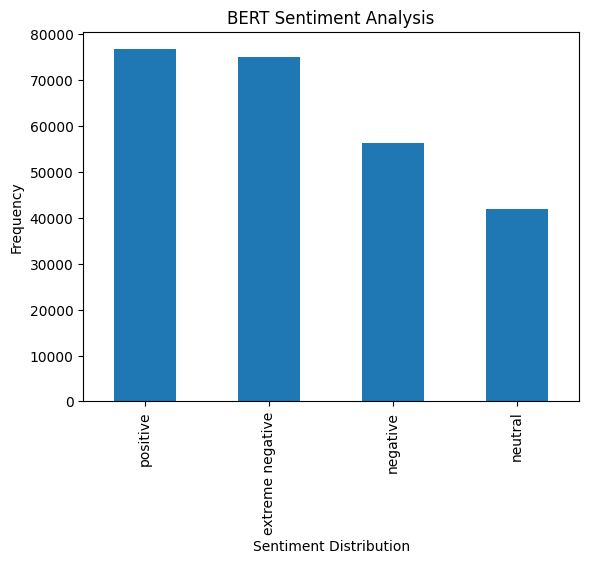

In [ ]:
import matplotlib.pyplot as plt

#analysis

print(df['predicted_label'].value_counts())

#visualize
df['predicted_label'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment Distribution')
plt.ylabel('Frequency')
plt.title('BERT Sentiment Analysis')
plt.show()

In [ ]:
# Map sentiment labels to numeric values
label_map = {0: 'extreme negative', 1: 'negative', 2: 'neutral', 3:'positive'}
df['predicted_label'] = df['predicted_label'].map(label_map)


In [ ]:
print(df.columns)
print(df.head())

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time', 'clean_text', 'predicted_label', 'month'],
      dtype='object')
  comment_id  score                                          self_text  \
0    kwcam5d     15  Pakistanis are dumb sometimes I swear, this is...   
1    kppuklp      1  Well, sounds like you made up your mind regard...   
2    lc3rfkg      1  Things that might be controversial one day are...   
3    kdbvkf5      2                                        🪂🪂🪂     🔻🔻🔻   
4    lpxymc7     13  Just to add to this. They don't know if those ...   

         subreddit     

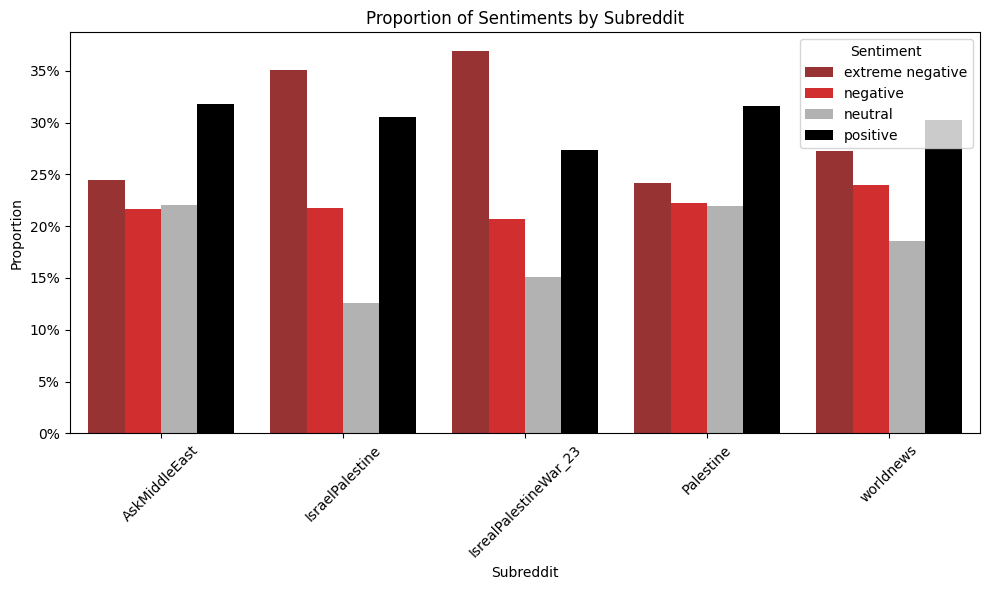

In [ ]:
import matplotlib.ticker as mticker

#group by subreddit and calculate proportion of extreme sentiment
subreddit_extremism = df.groupby('subreddit')['predicted_label'].value_counts(normalize=True).unstack().fillna(0)

subreddit_extremism = subreddit_extremism.reset_index()
plt.figure(figsize=(10, 6))
subreddit_extremism_melted = subreddit_extremism.melt(id_vars='subreddit', var_name='Sentiment', value_name='Proportion')
custom_colors = ['#A92222', '#EC1414', '#B2B2B2', '#0000']  # Replace with your desired colors

sns.barplot(
    data=subreddit_extremism_melted,
    x='subreddit',
    y='Proportion',
    hue='Sentiment',
    palette=custom_colors
)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

plt.title('Proportion of Sentiments by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


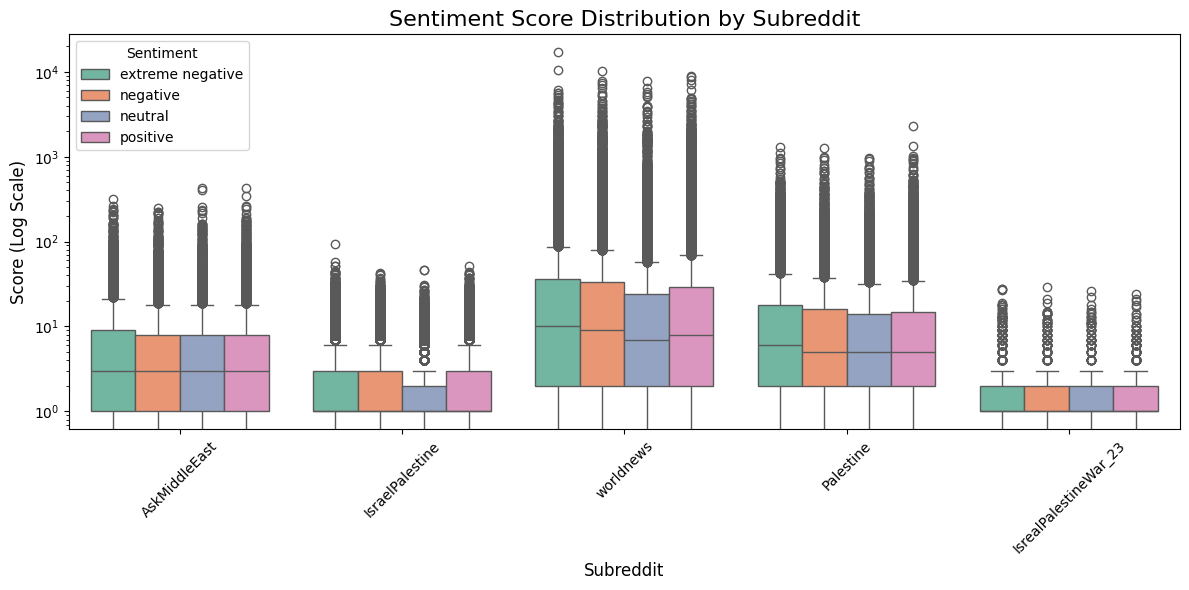

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("Set2", n_colors=df['predicted_label'].nunique())

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='subreddit', y='score', hue='predicted_label', palette=palette)

plt.yscale('log')

plt.title('Sentiment Score Distribution by Subreddit', fontsize=16)
plt.xlabel('Subreddit', fontsize=12)
plt.ylabel('Score (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', loc='upper left')

plt.tight_layout()

plt.show()


<ipython-input-23-8301897ea854>:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
<ipython-input-23-8301897ea854>:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
<ipython-input-23-8301897ea854>:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
<ipython-input-23-8301897ea854>:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


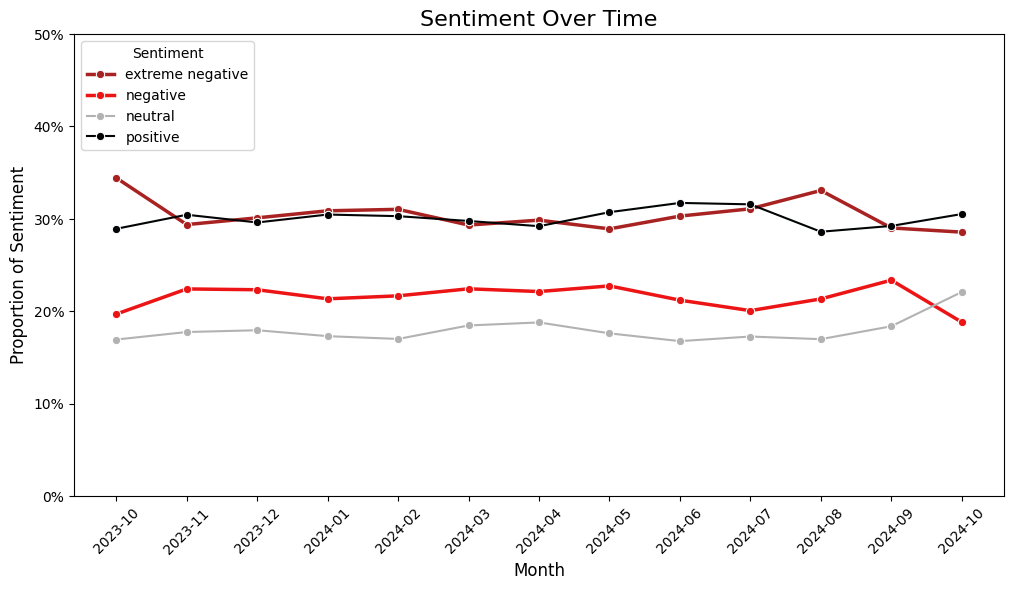

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['created_time'] = pd.to_datetime(df['created_time'])
df['month'] = df['created_time'].dt.to_period('M').astype(str)

sentiment_counts = df.groupby(['month', 'subreddit', 'predicted_label']).size().unstack(fill_value=0)

sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

sentiment_proportions = sentiment_proportions.reset_index()

df_melted = sentiment_proportions.melt(id_vars=['month', 'subreddit'],
                                       value_vars=['extreme negative', 'negative', 'neutral', 'positive'],
                                       var_name='Sentiment',
                                       value_name='Proportion')

plt.figure(figsize=(12, 6))

custom_colors = {
    'extreme negative': '#A92222',
    'negative': '#EC1414',
    'neutral': '#B2B2B2',
    'positive': '#020405'
}

for sentiment, color in custom_colors.items():
    linewidth = 2.5 if sentiment in ['extreme negative', 'negative'] else 1.5
    sns.lineplot(
        data=df_melted[df_melted['Sentiment'] == sentiment],
        x='month',
        y='Proportion',
        label=sentiment,
        color=color,
        linewidth=linewidth,
        marker='o',
        ci=None
    )

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

plt.title('Sentiment Over Time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Proportion of Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', loc='upper left')
plt.ylim(0, 0.5)
plt.show()


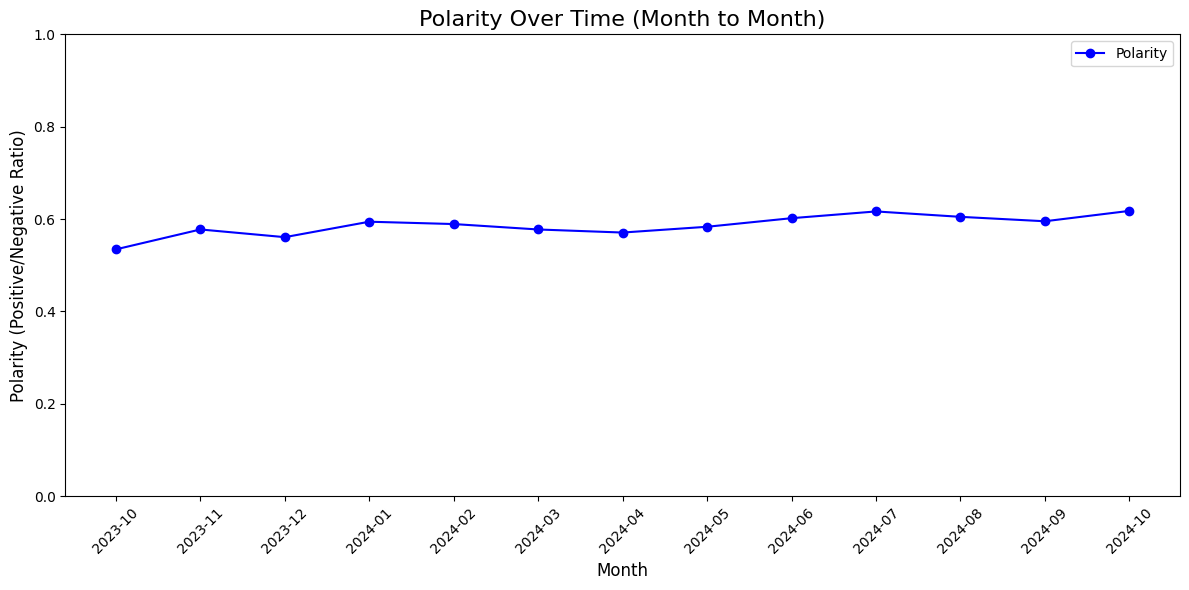

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['created_time'] = pd.to_datetime(df['created_time'])
df['month'] = df['created_time'].dt.to_period('M').astype(str)
sentiment_counts = df.groupby(['month', 'predicted_label']).size().unstack(fill_value=0)

positive_count = sentiment_counts.get('positive', 0)
negative_count = sentiment_counts.get('negative', 0) + sentiment_counts.get('extreme negative', 0)

polarity = positive_count / negative_count
polarity[negative_count == 0] = float('inf')

plt.figure(figsize=(12, 6))
plt.plot(polarity.index, polarity.values, marker='o', linestyle='-', color='b', label='Polarity')
plt.title('Polarity Over Time (Month to Month)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Polarity (Positive/Negative Ratio)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.0, 1)

plt.tight_layout()
plt.show()


In [ ]:
df['created_time'] = pd.to_datetime(df['created_time'])
df['month'] = df['created_time'].dt.to_period('M').astype(str)

df_controversial = df[df['controversiality'] == 1]

df_non_controversial = df[df['controversiality'] == 0]

sentiment_controversial = df_controversial.groupby(['month', 'predicted_label']).size().unstack(fill_value=0)
sentiment_non_controversial = df_non_controversial.groupby(['month', 'predicted_label']).size().unstack(fill_value=0)

positive_controversial = sentiment_controversial.get('positive', 0)
negative_controversial = sentiment_controversial.get('negative', 0) + sentiment_controversial.get('extreme negative', 0)
polarity_controversial = positive_controversial / negative_controversial
polarity_controversial[negative_controversial == 0] = float('inf')

positive_non_controversial = sentiment_non_controversial.get('positive', 0)
negative_non_controversial = sentiment_non_controversial.get('negative', 0) + sentiment_non_controversial.get('extreme negative', 0)
polarity_non_controversial = positive_non_controversial / negative_non_controversial
polarity_non_controversial[negative_non_controversial == 0] = float('inf')

plt.figure(figsize=(12, 6))

plt.plot(polarity_controversial.index, polarity_controversial.values, marker='o', linestyle='-', color='red', label='Controversial (1)')

plt.plot(polarity_non_controversial.index, polarity_non_controversial.values, marker='o', linestyle='-', color='blue', label='Non-Controversial (0)')

plt.title('Polarity Over Time: Controversial vs Non-Controversial Posts', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Polarity (Positive/Negative Ratio)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.0, 1)

plt.tight_layout()
plt.show()

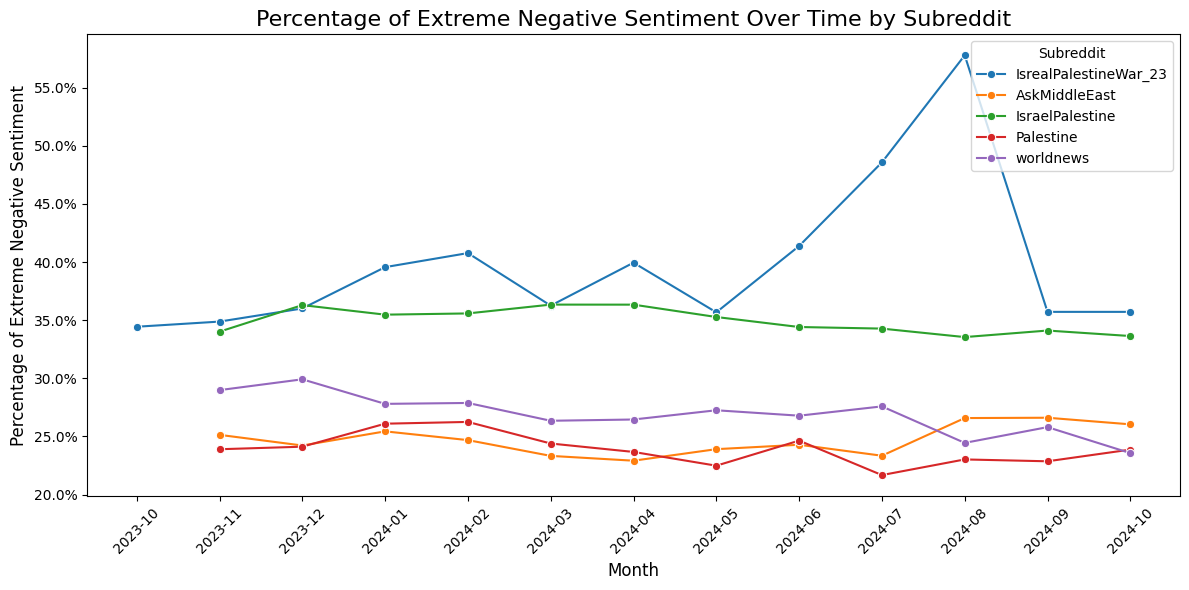

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

extreme_negative_data = df[df['predicted_label'] == 'extreme negative']

total_sentiments = df.groupby(['month', 'subreddit']).size()

extreme_negative_counts = extreme_negative_data.groupby(['month', 'subreddit']).size()

extreme_negative_proportions = (extreme_negative_counts / total_sentiments).fillna(0) * 100

extreme_negative_proportions = extreme_negative_proportions.reset_index()
extreme_negative_proportions.columns = ['Month', 'Subreddit', 'Proportion']

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=extreme_negative_proportions,
    x='Month',
    y='Proportion',
    hue='Subreddit',
    marker='o'
)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y}%'))

plt.title('Percentage of Extreme Negative Sentiment Over Time by Subreddit', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Percentage of Extreme Negative Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Subreddit', loc='upper right')
plt.tight_layout()
plt.show()


For my hypothesis:

In [ ]:
df['extreme_negative'] = df['predicted_label'] == 'extreme negative'

polarization_by_subreddit = df.groupby(['month', 'subreddit'])['extreme_negative'].mean().reset_index()

print(polarization_by_subreddit.head())



     month              subreddit  extreme_negative
0  2023-10  IsrealPalestineWar_23          0.344353
1  2023-11          AskMiddleEast          0.251372
2  2023-11        IsraelPalestine          0.340114
3  2023-11  IsrealPalestineWar_23          0.348780
4  2023-11              Palestine          0.238997


In [ ]:
from scipy.stats import f_oneway

subreddit_groups = [group['extreme_negative'].values for name, group in polarization_by_subreddit.groupby('subreddit')]
anova_result = f_oneway(*subreddit_groups)

print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')


ANOVA F-statistic: 54.7590015760508, p-value: 1.0320321151736122e-18


In [ ]:
import statsmodels.api as sm
import pandas as pd

df['month_numeric'] = pd.to_datetime(df['month']).astype(int) / 10**9

X = sm.add_constant(df['month_numeric'])
y = df['extreme_negative']

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       extreme_negative   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     82.56
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.03e-19
Time:                        18:09:02   Log-Likelihood:            -1.5962e+05
No. Observations:              250000   AIC:                         3.193e+05
Df Residuals:                  249998   BIC:                         3.193e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.9559      0.182     10.732

In [ ]:
df['extreme_negative_numeric'] = df['extreme_negative'].astype(int)

model = ols('extreme_negative_numeric ~ C(subreddit)', data=df).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

tukey_result = pairwise_tukeyhsd(df['extreme_negative_numeric'], df['subreddit'], alpha=0.05)
print(tukey_result)



                    sum_sq        df           F  PR(>F)
C(subreddit)    548.302540       4.0  659.556079     0.0
Residual      51956.496884  249995.0         NaN     NaN
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
        AskMiddleEast       IsraelPalestine   0.1059    0.0  0.0972  0.1145   True
        AskMiddleEast IsrealPalestineWar_23   0.1238    0.0  0.1019  0.1457   True
        AskMiddleEast             Palestine  -0.0028 0.9458  -0.013  0.0074  False
        AskMiddleEast             worldnews   0.0275    0.0  0.0186  0.0364   True
      IsraelPalestine IsrealPalestineWar_23   0.0179 0.1305 -0.0029  0.0388  False
      IsraelPalestine             Palestine  -0.1087    0.0 -0.1163  -0.101   True
      IsraelPalestine             worldnews  -0.0784    0.0 -0.0842 -0.0725   True

In [ ]:
print(df.columns)

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time', 'clean_text', 'predicted_label', 'month'],
      dtype='object')


In [ ]:
from scipy import stats

oct24 = sentiment_proportions[sentiment_proportions['month'] == '2024-09']['extreme negative'] + sentiment_proportions[sentiment_proportions['month'] == '2024-09']['negative']
oct23 = sentiment_proportions[sentiment_proportions['month'] == '2023-11']['extreme negative'] + sentiment_proportions[sentiment_proportions['month'] == '2023-11']['negative']


t_stat, p_value = stats.ttest_ind(oct24, oct23, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: 0.14246391520187976
P-value: 0.8908397382270445


In [ ]:
from scipy import stats

before_oct24 = sentiment_proportions[sentiment_proportions['month'] == '2024-09']['positive']
after_oct23 = sentiment_proportions[sentiment_proportions['month'] =='2023-11']['positive']

t_stat, p_value = stats.ttest_ind(before_oct24, after_oct23)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -0.5614766002806157
P-value: 0.5898507691982959


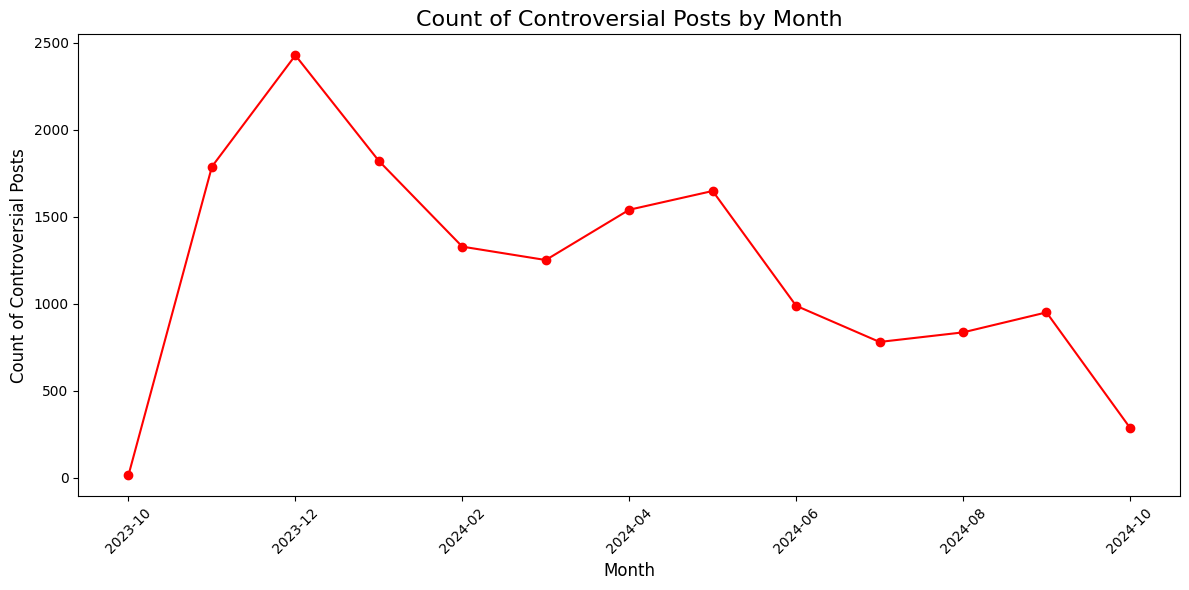

In [ ]:
import matplotlib.pyplot as plt

df_filtered = df[df['controversiality'] == 1].copy()

df_filtered['created_time'] = pd.to_datetime(df_filtered['created_time'])

df_filtered['month'] = df_filtered['created_time'].dt.to_period('M').astype(str)

monthly_controversial_count = df_filtered.groupby('month').size()

plt.figure(figsize=(12, 6))
monthly_controversial_count.plot(kind='line', marker='o', color='red')
plt.title('Count of Controversial Posts by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Controversial Posts', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
from scipy import stats

df['created_time'] = pd.to_datetime(df['created_time'])

before_oct = df[df['created_time'] < '2023-12-01']
after_oct = df[df['created_time'] >= '2024-12-01']

t_stat, p_value = stats.ttest_ind(before_oct['controversiality'], after_oct['controversiality'], equal_var=False)

print(before_oct)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


       comment_id  score  \
18        k92ggsa      7   
47        kb1xdml      7   
68        ka7btr6      1   
81        k84mr10     -3   
86        k9t6130      1   
...           ...    ...   
249932    k9oxgoa      3   
249944    k9dl73e     17   
249957    k9g2tcf      1   
249961    k5khclu      1   
249976    kbfap1o      2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       